# <p><strong>Visual Information Retrieval 2. &Uuml;bung</strong></p>

In [4]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import numpy
from sklearn.metrics import average_precision_score
from sklearn.neighbors import DistanceMetric

%matplotlib inline
%precision 3

'%.3f'

<h3>Funktion zur Bestimmung des Featurevektors aus dem Farbmittelwert des Bildes</h3>


In [5]:
def get_mean_feature(img):
    width = img.width
    height = img.height
    rgb = []
    
    for x in range(0, width):
        for y in range (0,height):
            r,g,b = img.getpixel((x, y))
            rgb.append([r, g, b])
            
    newRGB = numpy.mean(rgb, axis=0)
    
    return newRGB

### Funktion zur Bestimmung des Featurevektors aus Farbmittelwert und Sätigung des Bildes

In [6]:
def get_mean_sat_feature(saturation, img):
    width = img.width
    height = img.height    
    rgb = []
    
    for x in range(0, width):
        for y in range(0,height):
            r,g,b = img.getpixel((x,y))
            rgb.append([r,g,b])
            
    newRGB = numpy.mean(rgb,axis=0)
    
    featureVector = []
    lum = (newRGB[0] + newRGB[1] + newRGB[2]) / 3
    
    featureVector.append(lum)
    featureVector.append(saturation * (lum - b))
    featureVector.append(saturation * (lum - r))
    
    lumR = lum - featureVector[2]
    lumB = lum - featureVector[1]
    lumG = lum * 3 -  (lumR + lumB)
    
    if lumR  > 255:
        lumR = 255
    if lumG > 255:
        lumG = 255
    if lumB > 255:
        lumB = 255
    
    if lumR < 0:
        lumR = 0
    if lumG < 0:
        lumG = 0
    if lumB < 0:
        lumB = 0

    featureVector[0] = lumR
    featureVector[1] = lumG
    featureVector[2] = lumB
    
    return featureVector

<h3> Funktion zur Erstellung der Thumbnails </h3>

In [7]:
def create_thumbnail(img, pixel_size):
    xPartials = img.width / pixel_size
    yPartials = img.height / pixel_size
    
    img.thumbnail((xPartials,yPartials), Image.ANTIALIAS)

## Funktion zum Ermitteln der mAP

In [8]:
def compute_mean_average_precision(features, categories):
    
    dist = DistanceMetric.get_metric('euclidean')
    scores = 10000 - dist.pairwise(features, features) # convert to scores 
    
    meanAP = 0
    for i in range(0, len(features)):
        meanAP += average_precision_score((categories == categories[i]), scores[i])
    return meanAP / len(features)

Laden eines Bildes und Lesen der Pixelwerte

In [9]:
img = Image.open("./images/Test_10x5/banane_05.jpg")
pixels = numpy.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

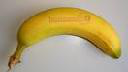

In [10]:
img

In [11]:
pixels.shape

(128, 72, 3)

<h3>Laden des Bildsets und Bestimmung der Featurevektoren und Kategorien</h3>


In [12]:
# load images
img_dir = "./images/Test_10x5/"

thumbnail_pixel_size = 2
data_path = os.path.join(img_dir,'*g')
thumbnail_mAPs = []

for thumbnail_pixel_size in range(thumbnail_pixel_size, 50):
    unique_cats = {}  # all categories
    cat_count = 0
    files = glob.glob(data_path)
    thumbnails, images, features, cat_names, cat_numbers = [], [], [], [], [] 

    for file in files:
        img = Image.open(file)
        images.append(img)

        original = get_mean_feature(img)
        features.append(original)

        create_thumbnail(img, thumbnail_pixel_size)
        rgb = get_mean_feature(img)
        thumbnails.append(rgb)

        filename = os.path.basename(file)
        cat_name = filename.split('_')[0]
        cat_names.append(cat_name)

        if cat_name not in unique_cats:
            unique_cats[cat_name] = cat_count
            cat_count = cat_count + 1
        cat_numbers.append(unique_cats[cat_name])

    features = numpy.array(features)
    cat_numbers = numpy.array(cat_numbers)
    thumbnail_pixel_size += 1
    mAP = compute_mean_average_precision(thumbnails, cat_numbers)
    thumbnail_mAPs.append(mAP)
    

### Laden der  Bilder und berrechnen der Featurevektoren mit Sätigung

In [39]:
# load images
img_dir = "./images/Test_10x5/"

thumbnail_pixel_size = 2
saturation = 0.2
data_path = os.path.join(img_dir,'*g')
all_mAPs = []

while saturation < 5.0:
    saturation_thumbnail_mAPs = []
    for thumbnail_pixel_size in range(thumbnail_pixel_size, 50):
        unique_cats = {}  # all categories
        cat_count = 0
        files = glob.glob(data_path)
        sat_thumbnails, sat_images, sat_features, sat_cat_names, sat_cat_numbers = [], [], [], [], [] 

        for file in files:
            img = Image.open(file)
            sat_images.append(img)

            create_thumbnail(img, thumbnail_pixel_size)
            rgb = get_mean_sat_feature(saturation,img)
            sat_features.append(rgb)

            filename = os.path.basename(file)
            cat_name = filename.split('_')[0]
            sat_cat_names.append(cat_name)

            if cat_name not in unique_cats:
                unique_cats[cat_name] = cat_count
                cat_count = cat_count + 1
            sat_cat_numbers.append(unique_cats[cat_name])

        sat_features = numpy.array(sat_features)
        sat_cat_numbers = numpy.array(sat_cat_numbers)
        thumbnail_pixel_size += 1
        mAP = compute_mean_average_precision(sat_features, sat_cat_numbers)
        saturation_thumbnail_mAPs.append(mAP)
    all_mAPs.append(saturation_thumbnail_mAPs)
    thumbnail_pixel_size = 2
    saturation += 0.2

In [14]:
cat_numbers

array([0, 1, 2, 3, 4, 1, 0, 3, 5, 6, 1, 7, 8, 9, 7, 0, 9, 4, 9, 3, 6, 6,
       4, 3, 2, 4, 4, 1, 8, 7, 1, 0, 2, 8, 9, 7, 3, 2, 8, 9, 5, 7, 2, 5,
       5, 6, 5, 6, 0, 8])

In [15]:
unique_cats

{'golfplatz': 0,
 'polizei': 1,
 'porsche': 2,
 'feuerwehr': 3,
 'apfelgruen': 4,
 'eiffeltag': 5,
 'eiger': 6,
 'sonnenblumeblau': 7,
 'apfelrot': 8,
 'banane': 9}

In [16]:
#features

In [17]:
#cat_count

## Anzeige der Bilder und Featurevektoren


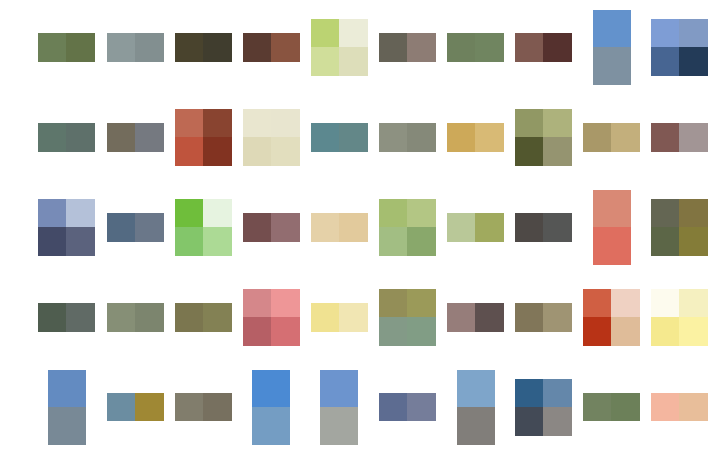

In [18]:
rows, cols = 5, 10
plt.figure(figsize=(12,8))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i])
    plt.axis('off')

<h3> Mean Image from Original Image </h3>

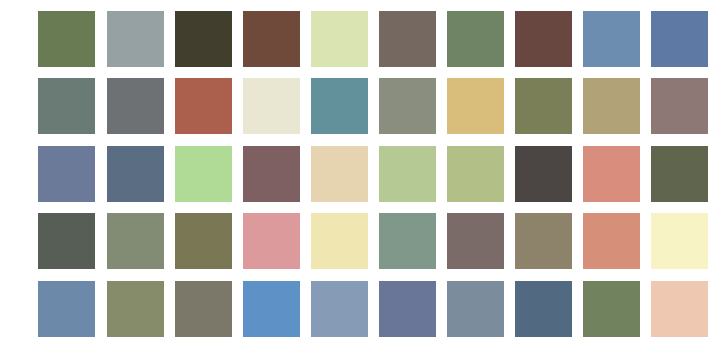

In [19]:
# Zeige Feature-Visualisierung als Farbe
plt.figure(figsize=(12,6))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    data = numpy.zeros([1, 1, 3], dtype=numpy.uint8)
    data[0,0,:] = features[i] 
    mean_img = Image.fromarray(data)
    plt.imshow(mean_img)
    plt.axis('off')

### Mean Image from Thumbnails 

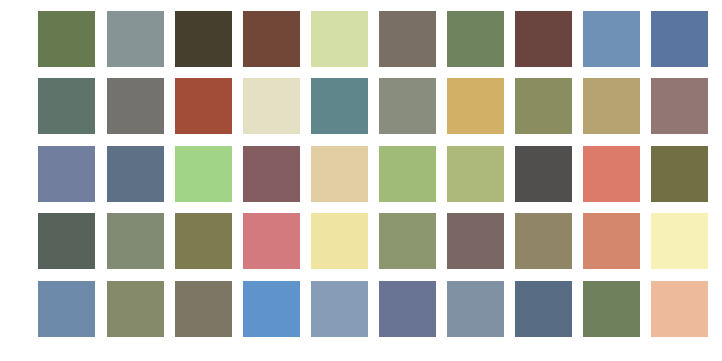

In [20]:
# Zeige Feature-Visualisierung als Farbe
plt.figure(figsize=(12,6))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    data = numpy.zeros([1, 1, 3], dtype=numpy.uint8)
    data[0,0,:] = thumbnails[i] 
    mean_img = Image.fromarray(data)
    plt.imshow(mean_img)
    plt.axis('off')

### Saturation Mean Image Feature Vector

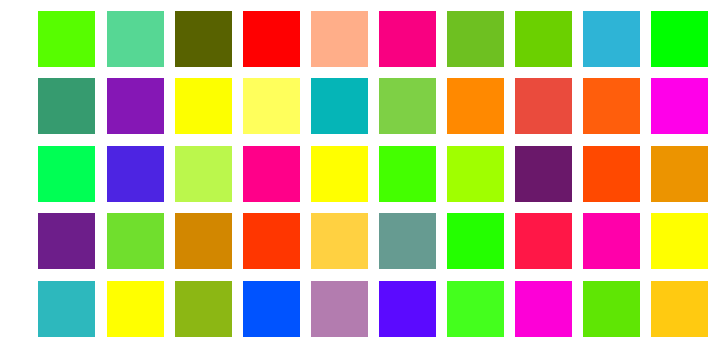

In [21]:
# Zeige Feature-Visualisierung als Farbe
plt.figure(figsize=(12,6))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    data = numpy.zeros([1, 1, 3], dtype=numpy.uint8)
    data[0,0,:] = sat_features[i] 
    mean_img = Image.fromarray(data)
    plt.imshow(mean_img)
    plt.axis('off')

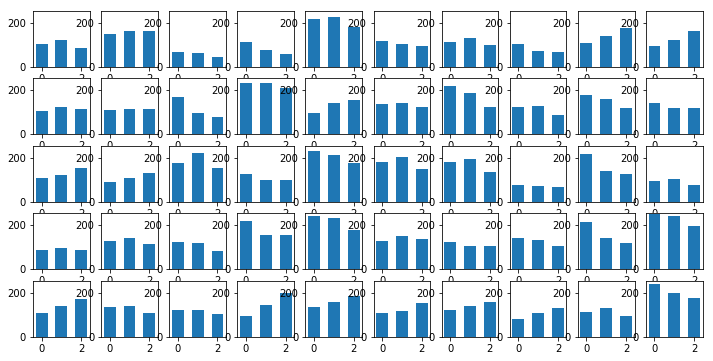

In [22]:
# Zeige Feature-Vektoren als Barplot
index = numpy.arange(0, features[0].shape[0]); # Zahlen von 0 bis 2 erzuegen
plt.figure(figsize=(12,6))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.bar(index, features[i], width=0.6)
    plt.ylim(0, 255)

In [23]:
mAP = compute_mean_average_precision(features, cat_numbers)
msg = "mAP = {0:5.3f}" 
str = msg.format(mAP)
print(str)

mAP = 0.563


## Test chain to showthe mAP without saturation

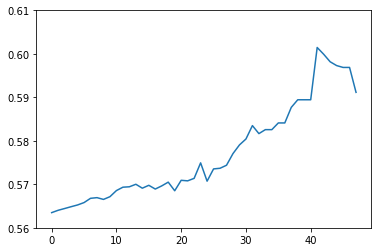

In [24]:
plt.plot(thumbnail_mAPs)
plt.ylim(0.56, 0.61)
plt.show()

### Test chain to show the mAP with saturation

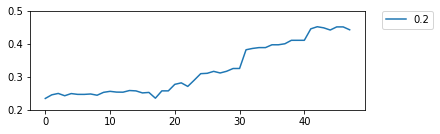

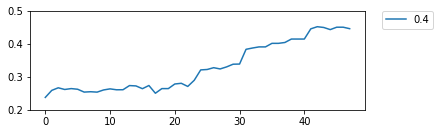

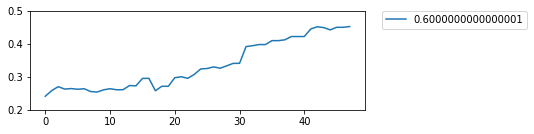

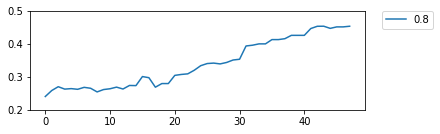

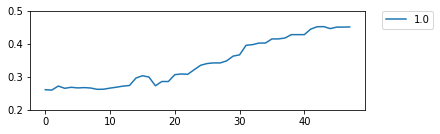

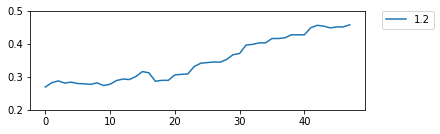

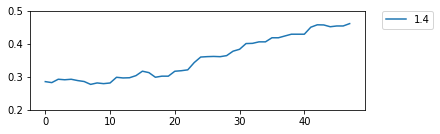

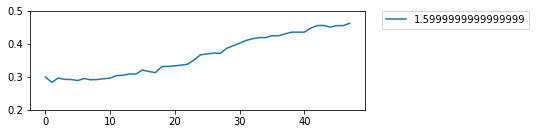

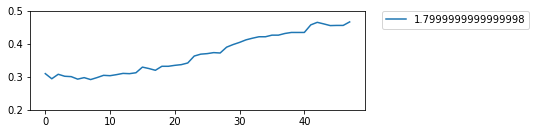

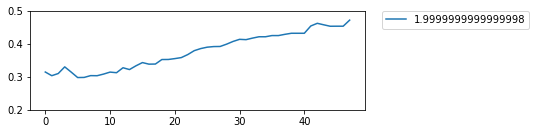

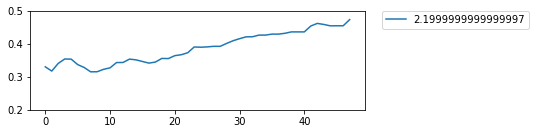

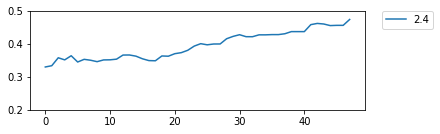

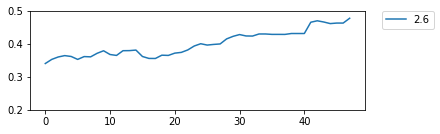

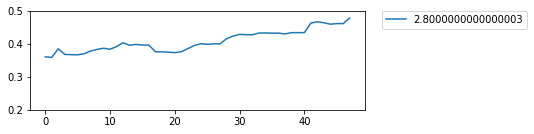

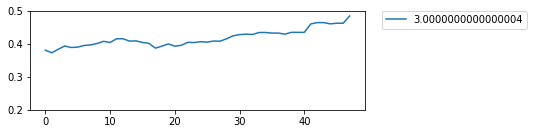

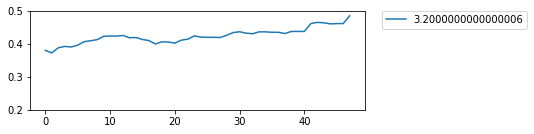

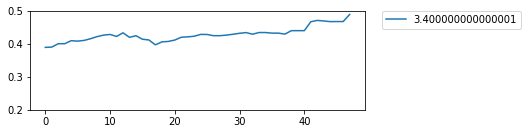

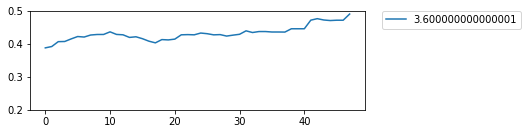

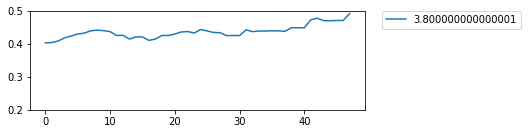

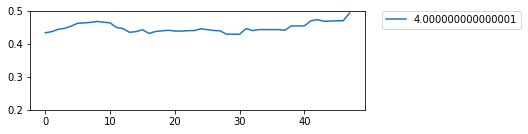

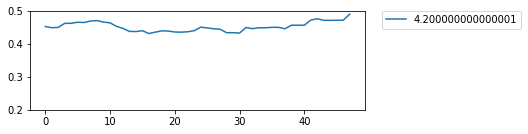

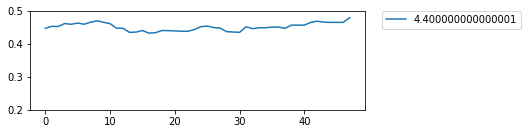

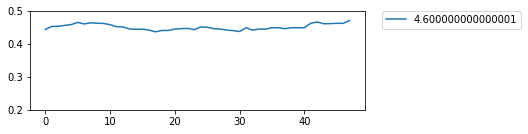

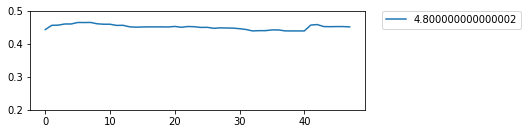

In [38]:
saturation = 0.2
for i in reversed(all_mAPs):
    plt.subplot(211)
    plt.ylim(0.2, 0.5)
    plt.xlim(2,50)
    plt.plot(i, label=saturation)
    saturation+=0.2
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()